In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from keras import layers ,regularizers
from keras.layers import Input, Add, Dense, Activation,BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D,Dropout
from keras.models import Model
from sklearn.preprocessing import LabelBinarizer

from keras.preprocessing.image import ImageDataGenerator # for Data augmentation
from keras.callbacks import ReduceLROnPlateau

from tensorflow import keras

In [ ]:
def loadData():
    ''' read training and testing images and reshape it to (m,28*28) and also read training labels
    
    - parameters 
    
        - no inputs

        - outputs :
            - trainingX : np array of shape (42000 ,28,28) contain training images 
            - trainingY : np array of shape (42000 ,) contain training data labels 
            - testX : np array of shape(28000,28,28)
    '''
    
    # trainPath = "../input/train.csv"
    # testPath = "../input/test.csv"
    # training_frame = pd.DataFrame(pd.read_csv(trainPath))
    # test_frame = pd.DataFrame(pd.read_csv(testPath))
    # trainingY = np.array(training_frame['label'])
    # index = ["pixel"+str(x) for x in range(784)] # generate list of columns indices of data frame to read pixels value by it 
    # trainingX = np.array(training_frame[index])
    # trainingX= trainingX.reshape(trainingX.shape[0],28,28,1)
    # testX = np.array(test_frame[index])
    # testX = testX.reshape(testX.shape[0],28,28,1)

    # LOADING DATA
    # Loading Data
    handwriting_mnist = keras.datasets.mnist
    (train_images,train_labels),(test_images,test_labels) = handwriting_mnist.load_data()
    train_images = train_images.reshape(len(train_images),28,28,1)
    test_images = test_images.reshape(len(test_images),28,28,1)

    return train_images, train_labels , test_images, test_labels
    

In [ ]:
trainingX , trainingY , testX, testY = loadData()

In [ ]:
# checking the dimensions
print("training x : ",trainingX.shape)
print("training y : ",trainingY.shape)
print("test x : ",testX.shape)

training x :  (60000, 28, 28, 1)
training y :  (60000,)
test x :  (10000, 28, 28, 1)


In [ ]:
def oneHot(y):
    ''' convert labels into one hot coding 
        parameters:
            - input : list of labels 
            - output : np array of one hot encoding 
    '''
    encoder = LabelBinarizer()
    y = encoder.fit_transform(y)
    return y

In [ ]:
# this fun plot example of our images data 
def plot_figures(x,y,nrows = 3, ncols=4):
    """Plot random figures of data.

    Parameters
    ----------
    x : Images
    y : labels
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    # generate random indexs 
    indexs = random.sample(range(0, len(y)), nrows*ncols)
    
    x = x.reshape(x.shape[0],28,28)
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=(10,10))
    for ind,i in enumerate(indexs):
        axeslist.ravel()[ind].imshow(x[i], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(y[i])
        axeslist.ravel()[ind].set_axis_off()
    #plt.tight_layout() # optional

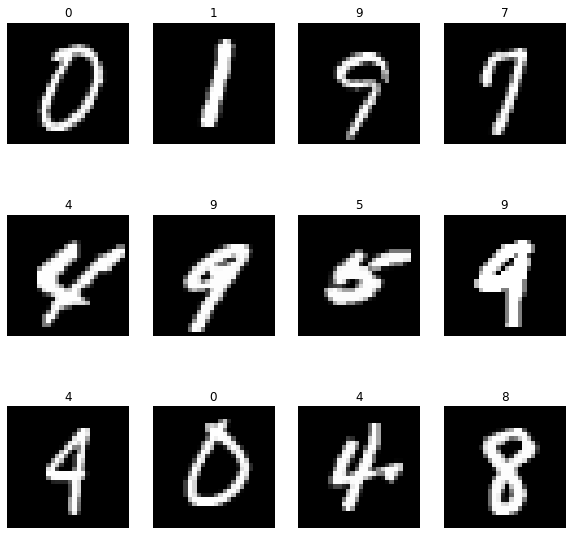

In [ ]:
plot_figures(x = trainingX , y = trainingY)

In [ ]:
## build our model 
def vgg16(trainingX , trainingY):
    """ implmentation of VGG16 model
    
    args:
        input:
            - trainingX : np array contain training data 
            - trainingY : np array contain training labels with out one hot coding -we will do this later in this fuc - 
            
        output:
            - mode : our keras mode of VGG16 
            - trainingY : return training y after one hot encoding
    
    Architecture :
            -> conv3-64 -> conv3-64
            -> maxpool 
            -> conv3-128 ->  conv3-128
            -> maxpool
            -> conv3-256 -> conv3-256 -> conv1-256
            -> maxpool
            -> conv3-512 -> conv3-512 -> conv1-512
            -> maxpool
            -> conv3-512 -> conv3-512 -> conv1-512
            -> maxpool
            -> FC100 'relu'
            -> FC50 'relu'
            -> FC10  'softmax'
            
    """

    # create input tensor 
    inputShape = trainingX.shape
    modelInput = Input(inputShape[1:])
    x = modelInput
    print(x.shape)
    # one hot encoding for our labels
    trainingY = oneHot(trainingY)
    
    # normalization 
    trainingX = trainingX /255.0
    print(trainingY.shape)
    # build the model
    
    x = Conv2D(64,(3,3),padding="same", input_shape=(28,28,1),activation = 'relu',strides=(1,1),name='conv1',kernel_initializer='glorot_uniform')(x)
    x = Conv2D(64,(3,3),padding="same",activation = 'relu',strides=(1,1),name='conv2',kernel_initializer='glorot_uniform')(x)
    
    x =   MaxPooling2D((3, 3), strides=(2, 2) ,padding ="same",name="maxpool1")(x)
    
    x = Conv2D(128,(3,3),padding="same",activation = 'relu',strides=(1,1),name='conv3',kernel_initializer='glorot_uniform')(x)
    x = Conv2D(128,(3,3),padding="same",strides=(1,1),name='conv4',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
    
    x = MaxPooling2D((3, 3), strides=(2, 2) ,padding ="same",name="maxpool2")(x)
    
    x = Conv2D(256,(3,3),padding="same",strides=(1,1),activation = 'relu',name='conv5',kernel_initializer='glorot_uniform')(x)
    x = Conv2D(256,(3,3),padding="same",strides=(1,1),activation = 'relu',name='conv6',kernel_initializer='glorot_uniform')(x)
    x = Conv2D(256,(1,1),padding="same",strides=(1,1),activation = 'relu',name='conv7',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
    
    x = MaxPooling2D((3, 3), strides=(2, 2) ,padding ="valid",name="maxpool3")(x)

    x = Conv2D(512,(3,3),padding="same",strides=(1,1),activation = 'relu',name='conv8',kernel_initializer='glorot_uniform')(x)
    x = Conv2D(512,(3,3),padding="same",strides=(1,1),activation = 'relu',name='conv9',kernel_initializer='glorot_uniform')(x)
    x = Conv2D(512,(1,1),padding="same",strides=(1,1),activation = 'relu',name='conv10',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
    
    x = MaxPooling2D((3, 3), strides=(2, 2) ,padding ="same",name="maxpool4")(x)
    
    x = Conv2D(512,(3,3),padding="same",strides=(1,1),activation = 'relu',name='conv11',kernel_initializer='glorot_uniform')(x)
    x = Conv2D(512,(3,3),padding="same",strides=(1,1),activation = 'relu',name='conv12',kernel_initializer='glorot_uniform')(x)
    x = Conv2D(512,(1,1),padding="same",strides=(1,1),activation = 'relu',name='conv13',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01))(x)
    
    x = MaxPooling2D((3, 3), strides=(2, 2) ,padding ="same",name="maxpool5")(x)
    
    #flatten x to be FC in next layer
    x = Flatten()(x)
    
    #fc layers
    x = Dense(100,name="fc1", kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = Dense(100,name="fc2", kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = Dense(10,name="fc3", kernel_initializer = 'glorot_uniform',activation='softmax')(x)

    #model
    model = Model(inputs = modelInput, outputs = x, name='vgg16')

    return model,trainingY
    
    
    

In [ ]:
model,trainingY = vgg16(trainingX,trainingY)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

(None, 28, 28, 1)
(60000, 10)
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 64)        640       
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 64)        36928     
                                                                 
 maxpool1 (MaxPooling2D)     (None, 14, 14, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 14, 14, 128)       73856     
                                                                 
 conv4 (Conv2D)              (None, 14, 14, 128)       147584    
                                                                 
 maxpool2 (MaxPooling2D)     (N

In [ ]:
# reduce LR 
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# Data augmentation
aug  = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        data_format = 'channels_last')  # randomly flip images
aug.fit(trainingX)

In [ ]:
from sklearn.model_selection import train_test_split
trainingX, X_val, trainingY, Y_val = train_test_split(trainingX, trainingY, test_size = 0.1, random_state=2)

In [ ]:
modelHistory = model.fit_generator(aug.flow(trainingX,
                    trainingY,batch_size = 64),
                    epochs = 40,
                    validation_data=(X_val,Y_val), 
                    shuffle=True,
                    verbose = 2,
                    callbacks = [lr_reduce])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/40
844/844 - 68s - loss: 2.6893 - accuracy: 0.7808 - val_loss: 0.5586 - val_accuracy: 0.9697 - lr: 0.0010 - 68s/epoch - 80ms/step
Epoch 2/40
844/844 - 52s - loss: 0.3770 - accuracy: 0.9671 - val_loss: 0.1871 - val_accuracy: 0.9808 - lr: 0.0010 - 52s/epoch - 62ms/step
Epoch 3/40
844/844 - 52s - loss: 0.2103 - accuracy: 0.9747 - val_loss: 0.1639 - val_accuracy: 0.9820 - lr: 0.0010 - 52s/epoch - 61ms/step
Epoch 4/40
844/844 - 52s - loss: 0.1768 - accuracy: 0.9763 - val_loss: 0.1777 - val_accuracy: 0.9778 - lr: 0.0010 - 52s/epoch - 61ms/step
Epoch 5/40
844/844 - 52s - loss: 0.1571 - accuracy: 0.9797 - val_loss: 0.1559 - val_accuracy: 0.9800 - lr: 0.0010 - 52s/epoch - 61ms/step
Epoch 6/40

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
844/844 - 52s - loss: 0.1448 - accuracy: 0.9811 - val_loss: 0.1799 - val_accuracy: 0.9795 - lr: 0.0010 - 52s/epoch - 61ms/step
Epoch 7/40
844/844 - 52s - loss: 0.0861 - accuracy: 0.9885 - val_loss: 0.0725 - val_accurac

In [ ]:
def plotModelHistory(modeHistory):
    # summarize history for accuracy
    history = modeHistory
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
plotModelHistory(modelHistory)

KeyError: ignored

In [ ]:
#save model
model.save_weights('vgg16_wieghts.h5')
model.save('vgg16-digitRecognizer_keras.h5')

In [ ]:
# create array for testY
m = testX.shape[0]
testY = np.zeros((m,1))
testY = model.predict(testX)

In [ ]:
model.evaluate(testX,oneHot(testY))

313/313 [==============================] - 5s 16ms/step - loss: 0.0198 - accuracy: 0.9960


[0.019807148724794388, 0.9959999918937683]

In [ ]:
testY.shape

(10000,)

In [ ]:
# plot some test image with there predicted label
finalY = np.argmax(testY,axis=1)
plot_figures(testX,finalY,nrows = 3, ncols=4)


In [ ]:
# save submission file 
frame = pd.DataFrame({'Label': finalY.T.squeeze()})
frame = frame.reset_index(drop=True)
frame.index += 1 
frame.to_csv("Digite Recognize.csv", index_label='ImageId')

In [ ]:
print(frame)

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/MNIST-params/base-model')